# Dataset 3 Feature Exploration

## 1. Imports and variable setup

In [1]:
# Import all libraries
import os
from roboflow import Roboflow
from IPython import display
import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Check image displays are good
# display.clear_output()
sys.path.append(str(Path.cwd().parent))
# Check ultralytics library is good
ultralytics.checks()

Ultralytics YOLOv8.0.238 🚀 Python-3.10.13 torch-2.1.2 CPU (Apple M1 Pro)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 58.0/460.4 GB disk)


In [3]:
# Setup Project directory path
project_dir = Path.cwd().parent

# Add roboflow data to the 'external' folder
project_dir = project_dir.joinpath("data/external")
load_dotenv(find_dotenv())  # Load in Environment variables for collecting roboflow data
DATASET_VERSION = 4

In [4]:
os.getenv

<function os.getenv(key, default=None)>

## 2. Load in Data

In [5]:
from dbdkillerai.data.make_dataset import grab_roboflow_data

# Grab third dataset. Defaults to data version 3, yolov8
rf_conn, rf_project, rf_dataset = grab_roboflow_data(rf_data_version=DATASET_VERSION,
                                                     project_dir=project_dir,
                                                     overwrite=True)

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.238, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to /Users/mreagles524/Documents/gitrepos/projects/DBD-Killer-AI/data/external in yolov8:: 100%|██████████| 3652/3652 [00:00<00:00, 8121.11it/s]


## 3. Feature Exploration

In [6]:
from dbdkillerai.utils import utils

### Check Preprocessing that took place on Roboflow

In [7]:
# Format and print the result
formatted_text = utils.format_preprocessing_dictionary(rf_project.version(DATASET_VERSION).preprocessing)
print("Data Preprocessing")
print("\n")
print(formatted_text)

Data Preprocessing


**auto-orient:**
True

**resize:**
    **format:** Stretch to
    **width:** 854
    **height:** 480

**remap:**
    **labels:** 
        **scratch_marks:** 
            **omit:** True
        **blind:** 
            **omit:** True
        **totem:** 
            **omit:** True
        **trap:** 
            **omit:** True
        **generator_completed:** 
            **override:** generator




### Check Data Augmentations taken place after preprocessing

In [8]:
# Format and print the result
formatted_text = utils.format_preprocessing_dictionary(
    rf_project.version(DATASET_VERSION).augmentation
)
print("Data Augmentations")
print("\n")
print(formatted_text)


Data Augmentations


**image:**
    **versions:** 3

**flip:**
    **horizontal:** True
    **vertical:** False




In [9]:
dataset_df = utils.process_yolov8_dataset(rf_dataset.location)
dataset_df.head()

,Split,Image,Width,Height,AspectRatio,activity,exit_gate,generator,hatchets,hook,locker,pallet,survivor,survivor_downed,survivor_hooked
0,Train,2023-12-04-21-29-02_mp4-436_jpg.rf.50b06ac7387...,854,480,1.779167,1,0,0,0,0,0,0,0,0,0
1,Train,2023-12-04-21-29-02_mp4-215_jpg.rf.21dd1b95334...,854,480,1.779167,0,0,1,0,0,0,0,1,0,0
2,Train,2023-12-04-21-29-02_mp4-120_jpg.rf.ab4e379a146...,854,480,1.779167,0,0,0,0,0,0,0,0,0,0
3,Train,1080pingame60fps_obs1080p60_mp4-54_jpg.rf.73c1...,854,480,1.779167,0,0,3,0,0,0,0,0,0,0
4,Train,2023-12-04-21-29-02_mp4-91_jpg.rf.ec9996e7722b...,854,480,1.779167,0,0,3,0,0,0,0,0,0,0


In [10]:
dataset_df.describe()

,Width,Height,AspectRatio,activity,exit_gate,generator,hatchets,hook,locker,pallet,survivor,survivor_downed,survivor_hooked
count,1820.0,1820.0,1.820000e+03,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000
mean,854.0,480.0,1.779167e+00,0.048352,0.067033,0.787912,0.057692,0.354945,0.181868,0.106593,0.124176,0.030769,0.010440
std,0.0,0.0,2.376530e-14,0.222121,0.254505,0.963357,0.342148,0.956074,0.495611,0.312222,0.366203,0.172739,0.101667
min,854.0,480.0,1.779167e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,854.0,480.0,1.779167e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,854.0,480.0,1.779167e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,854.0,480.0,1.779167e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,854.0,480.0,1.779167e+00,2.000000,2.000000,6.000000,4.000000,9.000000,4.000000,2.000000,3.000000,1.000000,1.000000


* Same aspect ratio for all at 1.779.
* 1820 images total
* Resolution: 854 x 480

### Check Distribution of labels

Since I can't check this from the roboflow AI, I have to do this manually from the downloaded dataset.

In [11]:
label_df = dataset_df.drop(columns=['Image', 'Width', 'Height', 'AspectRatio'])

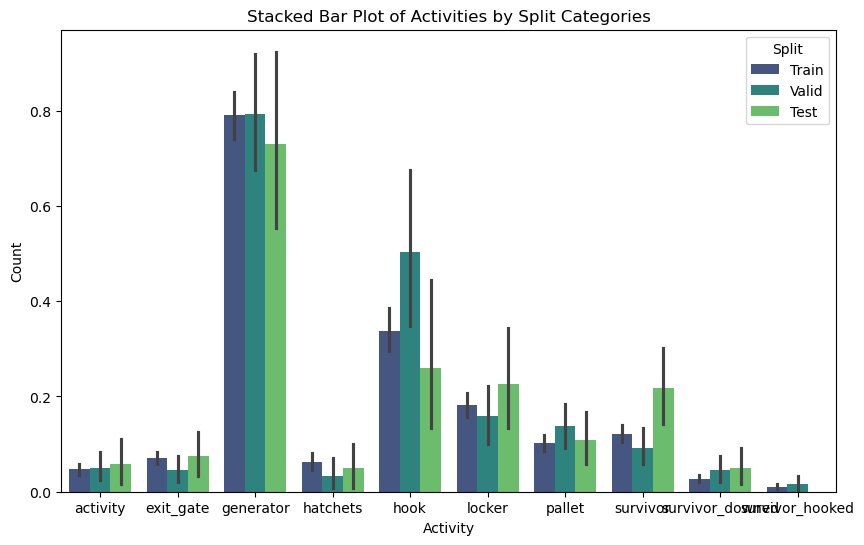

In [12]:
df_melted = pd.melt(label_df, id_vars=['Split'], var_name='Activity', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Activity', y='Count', hue='Split', data=df_melted, palette='viridis')

# Add labels and title
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Activities by Split Categories')
plt.show()

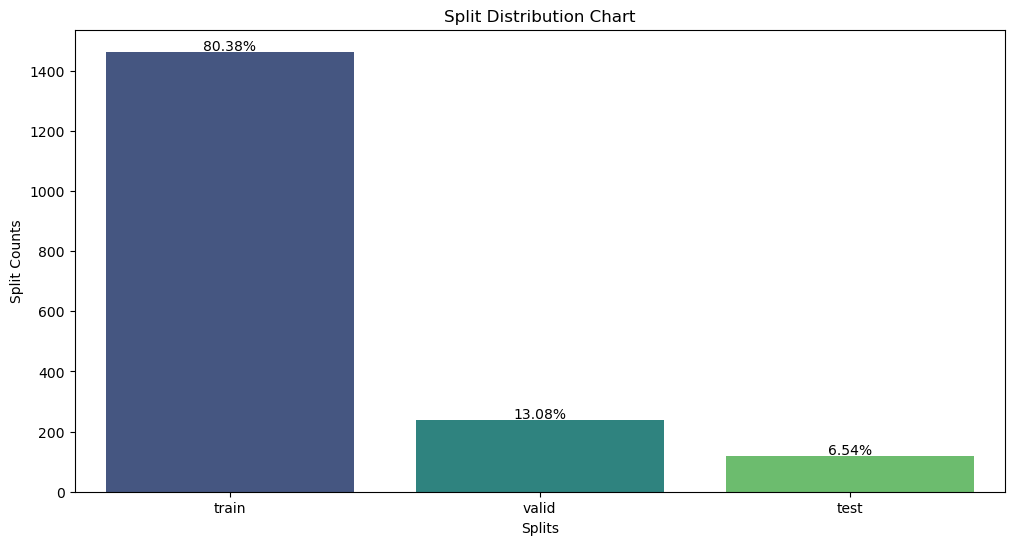

In [13]:
# Convert given classes and coutns to a pandas dataframe. Then graph it
split_counts_df = pd.DataFrame(list(rf_project.version(4).splits.items()), columns=['Split', 'Count'])
split_counts_df = split_counts_df.sort_values(by='Count', ascending=False)

split_counts_df['Percentage'] = (split_counts_df['Count'] / split_counts_df['Count'].sum()) * 100

# Create a distribution chart using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Split',
                 y='Count',
                 data=split_counts_df,
                 palette='viridis',
                 hue='Split')

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5,
            f'{height / split_counts_df["Count"].sum():.2%}',
            ha="center")

plt.title('Split Distribution Chart')
plt.xlabel('Splits')
plt.ylabel('Split Counts')

# Rotate x-axis text
plt.show()

In [14]:
split_counts_df['Percentage'] = (split_counts_df['Count'] / split_counts_df['Count'].sum()) * 100
split_counts_df

,Split,Count,Percentage
2,train,1463,80.384615
0,valid,238,13.076923
1,test,119,6.538462


### Preview some images and labels

In [15]:
labels = utils.load_labels_from_yaml(rf_dataset.location + "/data.yaml")
label_dict = {idx: label for idx, label in enumerate(labels)}

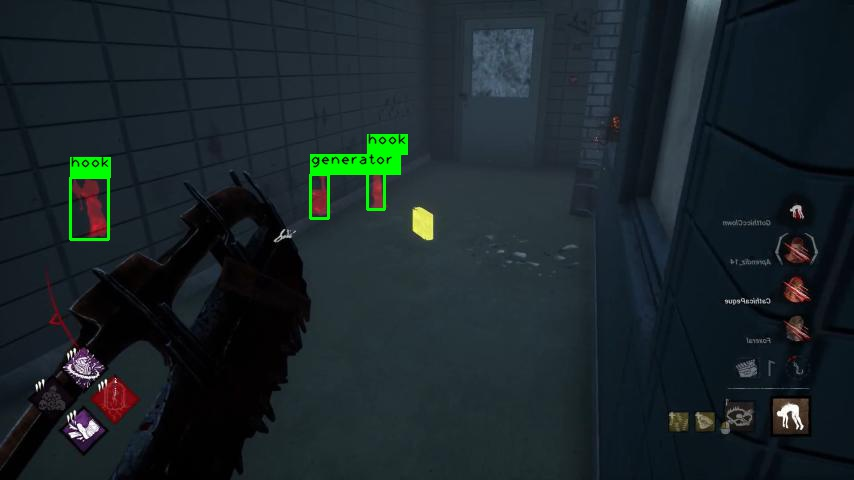

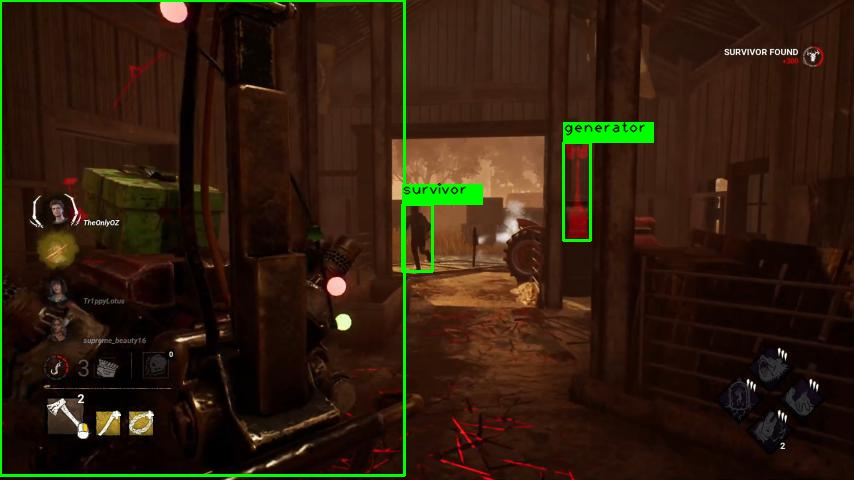

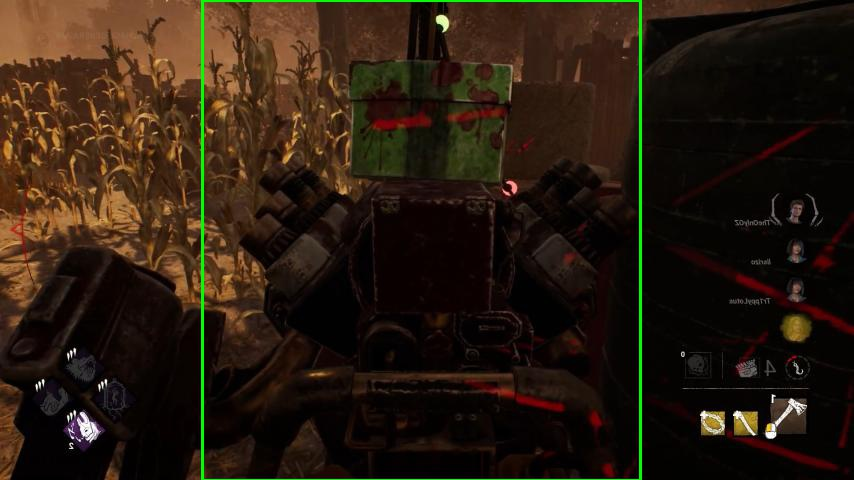

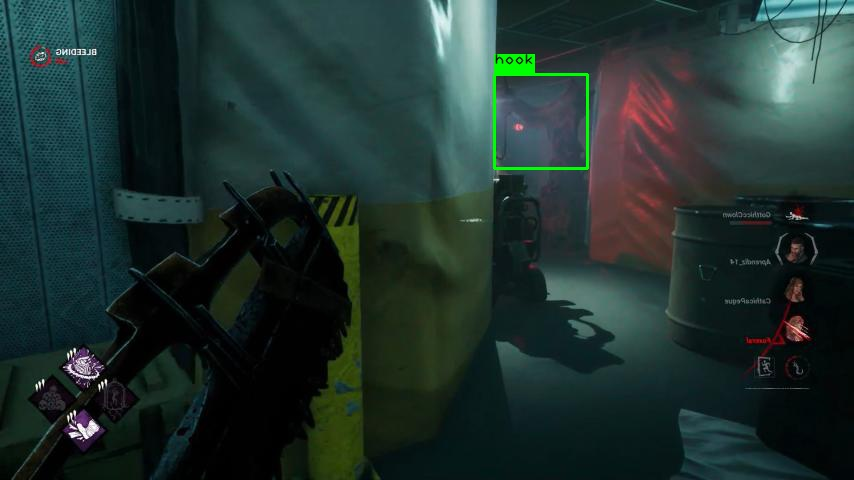

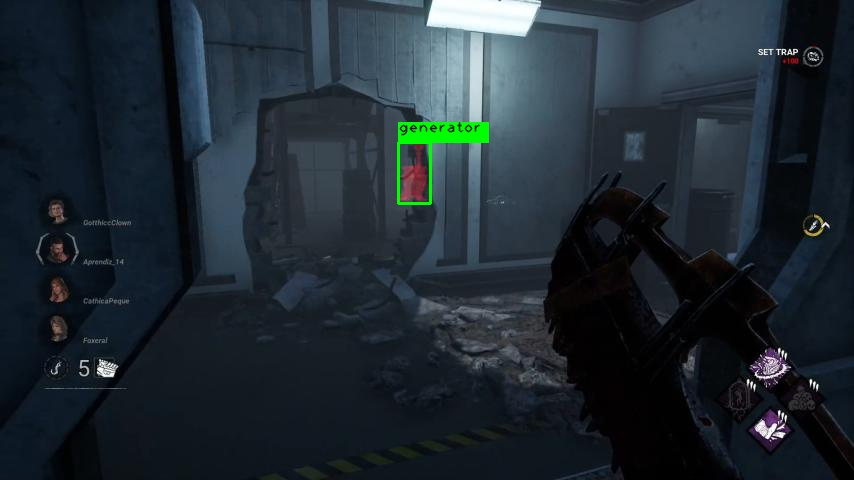

In [16]:
import random
import cv2

# Define the directories
image_dir = rf_dataset.location + '/train/images'
label_dir = rf_dataset.location + '/train/labels'

# Get a list of images
images = os.listdir(image_dir)

# Set the number of images to randomly display
num_images_to_display = 5  # Change this value to the desired number

# Randomly select images
selected_images = random.sample(images, num_images_to_display)

# For each selected image
for image_file in selected_images:
    # Read the image
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    # Get the corresponding label file
    label_file = image_file.replace('.jpg', '.txt')
    with open(os.path.join(label_dir, label_file), 'r') as f:
        # Each line in the label file represents a bounding box
        for line in f.readlines():
            # Each line is in the format: [class] [x_center] [y_center] [width] [height]
            # Note: the values are normalized to [0, 1], so you need to multiply them by the image's width and height
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center *= image.shape[1]
            y_center *= image.shape[0]
            width *= image.shape[1]
            height *= image.shape[0]

            # Convert to top-left x, y, bottom-right x, y
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Get the label for the class_id from the label dictionary
            label = label_dict.get(int(class_id), 'Unknown')

            # Add a filled background to the text
            cv2.rectangle(image, (x1, y1 - 20), (x1 + len(label) * 10, y1), (0, 255, 0), cv2.FILLED)

            # Add the label text to the image
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), 1, cv2.LINE_AA)

    # Save the image with bounding box and label to a temporary file
    temp_image_path = 'temp_image.jpg'
    cv2.imwrite(temp_image_path, image)

    # Display the image using IPython Image
    display(Image(filename=temp_image_path))

    # Remove the temporary image file
    os.remove(temp_image_path)